In [1]:
using Distributions
using Random
using DelimitedFiles
using ParticleFilters
using PyPlot
using StatsBase
using Images
using BenchmarkTools
using CUDA

## Load Data

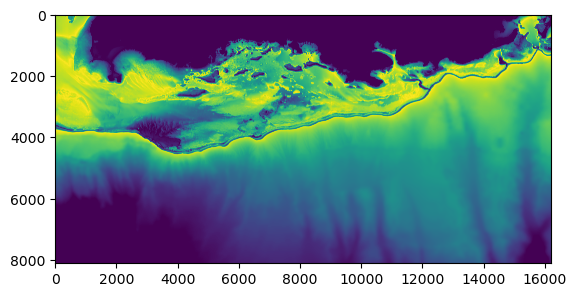

In [2]:
# Open the tiff file
# filename = "/home/amy/final_project_18337/PuertoRico_SouthWest_Color.tif"
filename = "PuertoRico_SouthWest_Color.tif"
img = load(filename)

function rgb_to_value(rgb_color::RGB{N0f8})
    # Interpolate between blue and red based on the green component
    green_component = green(rgb_color)
    value = 30-30 * (1 - green_component)

    # Return the value
    return value
end

# Convert from pixels to meters and vice versa
# ~40 miles, 16000px wide
# ~64000 meters

px_per_meter = 16000/64000

function px_to_meters(px)
    return px./px_per_meter
end

function meters_to_px(m)
    return m.*px_per_meter
end

function lookup_depth(x, y, map)
    # In meters
    # column, row (x, y) format. 0, 0 is top left of image    
    
    # Find the pixel with the closest x, y values
    x_idx = argmin(abs.(collect(1:size(map, 2)) .- x))
    y_idx = argmin(abs.(collect(1:size(map, 1)) .- y))
    
    # Look up the pixel value
    pixel_value = map[y_idx, x_idx] 
    
    return pixel_value 
end

# TODO: Fix mapping error - currently using pixels, NOT meters

# Apply the rgb_to_value function to the image
value_image = map(rgb_to_value, img)

# Display the value image
imshow(value_image)

bathy_map = value_image[1500:2500,6000:8000];

## Constants

In [3]:
SIM_TIME = 1000 # s
N_STEPS = 1001

SIM_MEASUREMENT_STD = 10 # Noise of simulated measurement
MODEL_MEASUREMENT_STD = 0.1 # Modeled noise value

ts = range(0, stop=SIM_TIME, length=N_STEPS)

# TODO: remove fixed timestamp
DELTA_T = ts[2] - ts[1]
rng = MersenneTwister(1)

MersenneTwister(1)

In [4]:
# Particle filter parameters
N_PARTICLES = 1000
INIT_STD_POS = 100 # Positional standard deviation
INIT_STD_ROT = 1 # Rotational standard deviation (radians)

PF_STD_POS = 0.1 # Positional standard deviation for particle filter updates
PF_STD_ROT = 0.01 # Positional standard deviation for particle filter updates


STATE_VEC_SIZE = 5 # x, y, θ, linear velocity, angular velocity

5

## Particle Filter Models

In [5]:
# Dyanmics Model
function glider_dynamics_model(x, u, rng)
    """
    inputs:
        x: state
        u: control input
    output:
        updated state (same shape as x)
    """
    
    x_pos, y_pos, θ, v, dθ = x
    in_thruster, in_rudder = u
    
    # Update position based on state
    x_step = x_pos + DELTA_T*v*cos(θ)
    y_step = y_pos + DELTA_T*v*sin(θ)
    θ_step = θ + DELTA_T*dθ

    # Update velocities based on input
    v_step = v + DELTA_T*(in_thruster-v)
    dθ_step = dθ + DELTA_T*in_rudder
    
    return [x_step, y_step, θ_step, v_step, dθ_step]
end

# Measurement model (computes likelihood of measurement, given previous state, action, and current state)
# Note: our measurement only depends on current state
function glider_measurement_model(x1, u, x2, y)
    """
    inputs:
        x1: current state
        u: control input
        x2: next state
        y: measurement
    output:
        likelihood (float)
    """
    
    # State vector: x, y, θ, linear velocity, angular velocity
    x_pos, y_pos, θ, v, dθ = x2
    measured_depth = y

    model_depth = lookup_depth(x_pos, y_pos, bathy_map)

    dist = Normal(model_depth, MODEL_MEASUREMENT_STD)
    pdf_value = pdf(dist, measured_depth)

    return pdf_value
end

glider_measurement_model (generic function with 1 method)

## Generate Dataset

In [6]:
function generate_random_func()
    n = 5
    a = 0.05
    A = rand(-a:0.01:a, n)
    B = rand(-a:0.01:a, n)
    random_func(t) = sum(A[i]*sin.(B[i]*t) * A[i+1]*cos.(B[i+1]*t) for i in 1:n-1)
    return random_func
end

function generate_data(ts, func)
    output = similar(ts)
    for (i, t) in enumerate(ts)
        output[i] = func(t)
    end
    return output
end

function simulate_trajectory(ts, in_thruster, in_rudder; start_x=0, start_y=0, start_θ=0)
    xs = similar(ts)
    ys = similar(ts)
    vs = similar(ts)
    θs  = similar(ts)
    dθs = similar(ts)
    
    # Initialize state to 0
    xs[1] = start_x # X position
    ys[1] = start_y # Y position
    vs[1] = 0 # Velocity
    θs[1] = start_θ # Heading
    dθs[1] = 0 # Angular Velocity
    
    for (i, t) in enumerate(ts[1:end-1])
        state = [xs[i], ys[i], θs[i], vs[i], dθs[i]]
        u = [in_thruster[i], in_rudder[i]]
        xs[i+1], ys[i+1], θs[i+1], vs[i+1], dθs[i+1] = 
            glider_dynamics_model(state, u, rng)
    end
    
    return xs, ys, θs, vs, dθs
end

function simulate_measurements(xs, ys, map)
    # TODO: Add noise terms
    output = similar(xs)
    
    for (i, (x, y)) in enumerate(zip(xs, ys))
        output[i] = lookup_depth(x, y, map)
    end
    
    return output
end

simulate_measurements (generic function with 1 method)

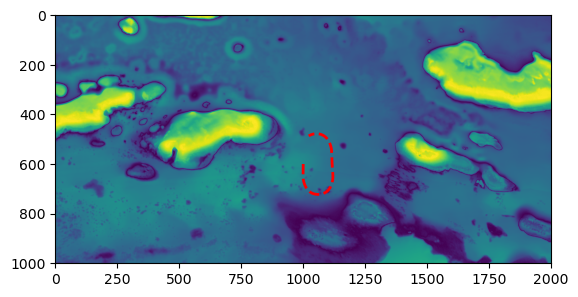

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000017FC3EC77C0>

In [7]:
START_X = 1000 
START_Y = 600
START_θ = π/2

# in_thruster = generate_data(ts, generate_random_func())
in_thruster = 0.5*ones(size(ts))
in_rudder = 0.1*generate_data(ts, generate_random_func())

xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder, 
    start_x=START_X, start_y=START_Y, start_θ=START_θ)

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(xs,ys,"r--", lw=2)

In [8]:
measurements = simulate_measurements(xs, ys, bathy_map);

## ParticleFilters.jl

In [9]:
function compute_initial_particles()
    init_particles = Vector{Vector{Float64}}(undef, N_PARTICLES)
    
    dist_pos_init = Normal(0, INIT_STD_POS)
    dist_rot_init = Normal(0, INIT_STD_ROT)
    
    for i in 1:N_PARTICLES
        # Generate sample
        x = START_X + rand(dist_pos_init)
        y = START_Y + rand(dist_pos_init)
        θ = START_θ + rand(dist_rot_init)
        init_particles[i] = [x, y, θ, 0, 0]
    end

    return init_particles
end

compute_initial_particles (generic function with 1 method)

In [10]:
pf_model = ParticleFilterModel{Vector{Float64}}(glider_dynamics_model, glider_measurement_model);

fil = BootstrapFilter(pf_model, N_PARTICLES) # Takes in model, number of particles

# construct initial belief
b0 = ParticleCollection(compute_initial_particles())

# Temporary---------------------------------
inputs = [in_thruster, in_rudder]

# Preallocate the output vector for performance
us = Vector{Vector{Float64}}(undef, length(in_thruster))

# Convert each pair of values to a vector and store in the output vector
for i in 1:length(in_thruster)
    us[i] = [inputs[1][i], inputs[2][i]]
end
# ------------------------------------------

# bs = runfilter(fil, b0, us, measurements); # Actually compute results. Inputs: filter, initial particles, data 

In [15]:
# @btime runfilter(fil, b0, us, measurements); # Actually compute results. Inputs: filter, initial particles, data 

In [16]:
# @btime 3
# results = @benchmark runfilter(fil, b0, us, measurements) evals=1 samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 14.085 s (14.30% GC) to evaluate,
 with a memory estimate of 46.04 GiB, over 36016987 allocations.

In [17]:
# results = @benchmark 3 evals=1000 samples=1

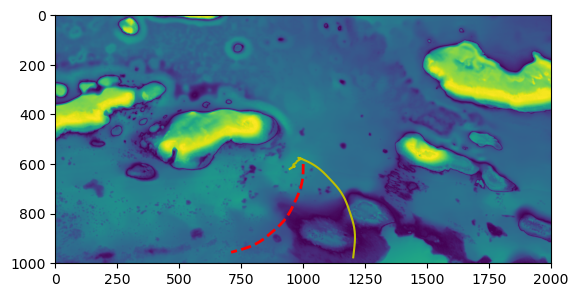

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000023646FDDFC0>

In [18]:
# # TODO: make this less redundant
# filtered_xs = [m[1] for m in map(mean, bs)]
# filtered_ys = [m[2] for m in map(mean, bs)]

# fig, ax = PyPlot.subplots()
# ax.imshow(-bathy_map)
# ax.plot(xs,ys,"r--", lw=2)
# ax.plot(filtered_xs, filtered_ys, "y")

## Custom ParticleFilter 

In [14]:
all_particles = ones(STATE_VEC_SIZE, N_PARTICLES, N_STEPS)
particles = ones(STATE_VEC_SIZE, N_PARTICLES)
new_particles = ones(STATE_VEC_SIZE, N_PARTICLES)
weights = ones(N_PARTICLES)


dist_pos_init = Normal(0, INIT_STD_POS)
dist_rot_init = Normal(0, INIT_STD_ROT)

dist_pos_update = Normal(0, PF_STD_POS)
dist_rot_update = Normal(0, PF_STD_ROT)


for i in range(1, N_PARTICLES)
    # Generate sample
    x = START_X + rand(dist_pos_init)
    y = START_Y + rand(dist_pos_init)
    θ = START_θ + rand(dist_rot_init)
    
    particles[:,i] = particles[:,i].*[x, y, θ, 0, 0]
end

In [15]:
zeros(Float32, N_PARTICLES)
x

LoadError: UndefVarError: x not defined

In [24]:
# Load initial particles onto GPU (_d means stored on device)
using CUDA

# Initialize particles
x = Float32.(START_X .+ rand(dist_pos_init, N_PARTICLES))
y = Float32.(START_Y .+ rand(dist_pos_init, N_PARTICLES))
θ = Float32.(START_θ .+ rand(dist_rot_init, N_PARTICLES))
v = zeros(Float32, N_PARTICLES)
dθ = zeros(Float32, N_PARTICLES)

# Particles = Vector containing CuArray for each state variable 
# Vector{CuArray}(undef, 5)
# particles = [broadcast(tuple, x[i], y[i], θ[i], v[i], dθ[i]) for i in 1:length(x)]
# particles_d = CuArray(map(x -> (x[1], x[2], x[3], x[4], x[5]), particles))
# particles_d = CuArray([x', y', θ', v', dθ'])

# TODO: THIS IS TEMPORARY
# particles_d = cu(x)
particles_d = CuArray(rand(Float32, 5, N_PARTICLES))

# Load measurements and control inputs onto GPU
in_thruster_32 = Float32.(in_thruster)
in_rudder_32 = Float32.(in_rudder)
inputs_d = [CuArray([in_thruster_32[i], in_rudder_32[i]]) for i in 1:length(in_thruster_32)]

measurements_32 = Float32.(measurements)
measurements_d = [CuArray([measurements_32[i],]) for i in 1:length(measurements_32)];

In [25]:
particles_d

5×1000 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.793728    0.454142   0.14347   0.509508  …  0.889362  0.14212    0.616163
 0.590377    0.287526   0.252648  0.971211     0.129708  0.355994   0.652341
 0.362604    0.544981   0.871993  0.541794     0.36833   0.0641652  0.577415
 0.00329131  0.141051   0.968261  0.368514     0.629361  0.465041   0.125142
 0.14316     0.0812911  0.127168  0.752133     0.59066   0.829692   0.93445

In [30]:
function glider_resampling_func!(particles, input, measurement)
#     i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
#     if i <= length(particles[1])
#         @inbounds particles[1][i]
#     end
    
    
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    for i = index:stride:length(particles)
        @inbounds particles[1, i] = i
        @inbounds particles[2, i] = i
    end
    
    return nothing
#     particles[1]
#     index = (blockIdx().particles - 1) * blockDim().particles + threadIdx().particles
#     stride = gridDim().particles[1] * blockDim().particles[1]

#     for i = index:stride:length(particles[1])
#         @inbounds particles[1][1] += 2000
#     end
    # function gpu_add3!(y, x)
#     index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
#     stride = gridDim().x * blockDim().x
#     for i = index:stride:length(y)
#         @inbounds y[i] += x[i]
#     end
#     return
# end
end

function glider_propogation_func!()
    return nothing
end

# function run_gpu_filter!
    
#     # Initialize weights vector
# #     weights = ones(Float32, length(particles[1]))
    
# #     weights_d = CUDA.fill(1.0f0, length(particles))
# #     particles
    
# #     for (u, y) in enumerate(zip(inputs, measurements))
# #         print('.')
        
# #         # TODO: Ensure likelihood can't be too small
# #         update_weights_gpu!(particles, u, y, weights)
# #     end
#     return
# end

# function run_gpu_filter!(particles, dynamics_model, measurement_model, inputs, measurements)
    
# end

# function update_weights_gpu!(particles, input, measurement, weights)   
#     index = (blockIdx().particles[1] - 1) * blockDim().particles[1] + threadIdx().particles[1]
#     stride = gridDim().particles[1] * blockDim().particles[1]
#     for i = index:stride:length(particles[1])       
#         # TODO: Add support for measurement models that depend on next state
#         # Replace 0 with next state data
#         @inbounds weights[i] += 10  # TODO! #measurement_model(particles[i], input, 0, measurement)
#     end
# end

# TODO: left off here
# make this use resampling_func (update particles) and propogation_func 
# At each step, save results to CPU ()

# function bench_gpu_filter!(particles, func)
    
    
    # TODO: Need to write a kernel for each parallelized function. Put the rest of the particle filter in this function,
    # including saving results
    # Custom parts = kernel functions for weighting (resampling) and propogation. start with stub, add one piece at a time. 
    # Save results at each step

function bench_gpu_filter!(particles, inputs, measurements, resampling_func!, propogation_func!)
    # Initialize weights vector
    weights_d = CUDA.fill(1.0f0, length(particles[1]))

    num_steps = length(inputs)
    num_particles = size(particles)[2]
    
    for idx in range(1, num_steps)
        u = inputs[idx]
        y = measurements[idx]
        
        # TODO: Optimize threads vs blocks
        # TODO: see if this can be abstracted and not run in inner loop
        # Resample particles with GPU
        resampling_kernel = @cuda launch=false resampling_func!(particles, u, y)
        resampling_config = launch_configuration(resampling_kernel.fun)
        resampling_threads = min(num_particles, resampling_config.threads)
        resampling_blocks = cld(num_particles, resampling_threads)

        display("Resampling threads: $resampling_threads")
        display("Resampling blocks: $resampling_blocks")

#         a = u .+ 10
#         b = y .+ 20
        
        CUDA.@sync begin
            resampling_kernel(particles, u, y; threads=resampling_threads, blocks=resampling_blocks)
        end
#         resampling_func!(particles, inputs, measurements)
        
    end
#     inputs
#     for (u, y) in enumerate(zip(inputs, measurements))
        
#         print(u)
#         print(y)
#         print('.')
        
        # TODO: Ensure likelihood can't be too small
#         update_weights_gpu!(particles, u, y, weights)
#     end

    
#     resampling_kernel = @cuda launch=false run_gpu_filter!(particles, inputs, measurements)
#     resampling_config = launch_configuration(kernel.fun)
#     resampling_threads = min(length(particles[1]), config.threads)
#     resampling_blocks = cld(length(particles[1]), threads)

#     display(threads)
#     display(blocks)

#     CUDA.@sync begin
#         resampling_kernel(particles, inputs, measurements; threads, blocks)
# #         kernel(particles, func; threads, blocks)
#     end
end

bench_gpu_filter!(particles_d, inputs_d, measurements_d, glider_resampling_func!, glider_propogation_func!)
particles_d


# function test_func!(part)
#     display(part[1])
#     display("here")
#     @cuprintln("print testing")
#     @cuprintln(part[1])
# end

# bench_gpu_filter!(particles_d, test_func!)

# test_func!(particles_d)



# # @btime bench_gpu4!($y_d, $x_d)

# # run_gpu_filter!(particles_d, inputs_d, measurements_d)

# @cuda threads=16 run_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# synchronize()


# function parallel_add!(y, x)
#     Threads.@threads for i in eachindex(y, x)
#         @inbounds y[i] += x[i]
#     end
#     return nothing
# end


"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

"Resampling threads: 768"

"Resampling blocks: 2"

5×1000 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 1.0         2.0        3.0       4.0       …  999.0        1000.0
 1.0         2.0        3.0       4.0          999.0        1000.0
 0.362604    0.544981   0.871993  0.541794       0.0641652     0.577415
 0.00329131  0.141051   0.968261  0.368514       0.465041      0.125142
 0.14316     0.0812911  0.127168  0.752133       0.829692      0.93445

In [29]:
size(particles_d)[2]

1000

In [26]:
# test = cu([rand(dist_pos_init, N_PARTICLES); rand(dist_pos_init, N_PARTICLES)])
# test[1]

temp1 = [1,2,3]
temp2 = [4,5,6]
A = Float32[temp1'; temp2']

# Create a 2x3 matrix on the GPU with Float32 element type
A_d = cu(A)

2×3 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 1.0  2.0  3.0
 4.0  5.0  6.0

In [95]:
typeof(measurements_d)

Vector{CuArray{Float32, 1, DeviceBuffer}} (alias for Array{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, 1})

In [96]:
# function gpu_add3!(y, x)
#     index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
#     stride = gridDim().x * blockDim().x
#     for i = index:stride:length(y)
#         @inbounds y[i] += x[i]
#     end
#     return
# end

In [164]:
# # function run_gpu_filter!(particles, dynamics_model, measurement_model, inputs, measurements)
    
# # end

# function update_weights_gpu!(particles, input, measurement, measurement_model, weights)
#     index = (blockIdx().particles - 1) * blockDim().particles + threadIdx().particles
#     stride = gridDim().particles * blockDim().particles
#     for i = index:stride:length(particles)       
#         # TODO: Add support for measurement models that depend on next state
#         # Replace 0 with next state data
#         @inbounds weights[i] = measurement_model(particles[i], input, 0, measurement)
#     end
# end

# function run_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
#     # Initialize weights vector
#     weights_d = CUDA.fill(1.0f0, length(particles))
    
#     for (u, y) in enumerate(zip(inputs, measurements))
#         print('.')
        
#         # TODO: Ensure likelihood can't be too small
#         update_weights_gpu!(particles, u, y, measurement_model, weights_d)
#     end
# end

# function bench_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
# # function bench_gpu_filter!(particles, func)
#     kernel = @cuda launch=false run_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
#     config = launch_configuration(kernel.fun)
#     threads = min(length(particles), config.threads)
#     blocks = cld(length(particles), threads)

#     display(threads)
#     display(blocks)

#     CUDA.@sync begin
#         kernel(particles, inputs, measurements, measurement_model, dynamics_model; threads, blocks)
# #         kernel(particles, func; threads, blocks)
#     end
# end

# bench_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# bench_gpu_filter!(particles_d, inputs_d, measurements_d)



# # function test_func!(part)
# #     display(part[1])
# #     display("here")
# #     @cuprintln("print testing")
# #     @cuprintln(part[1])
# # end

# # bench_gpu_filter!(particles_d, test_func!)

# # test_func!(particles_d)



# # # @btime bench_gpu4!($y_d, $x_d)

# # # run_gpu_filter!(particles_d, inputs_d, measurements_d)

# # @cuda threads=16 run_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# # synchronize()

10-element Vector{Float32}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [ ]:

# struct CustomParticleFilter
#     dynamics_model
#     measurement_model
# end

# # TODO: left off here
# function run_custom_filter!(filter, particles, inputs, measurements)
    
#     for (t_idx, (t, m, in_th, in_rud)) in enumerate(zip(ts, measurements, in_thruster, in_rudder))
#         print('.')
#         all_particles[:,:,t_idx] = particles


#         # Update weights based on observation ---------------------
#         # Compute relative likelihoods
#         for (p_idx, p) in enumerate(eachcol(particles))
#             weights[p_idx] = compute_likelihood(p, m, bathy_map)

#             # Ensure likelihood can't be too small
#             if weights[p_idx] < 0.000000001
#                 weights[p_idx] = 0.000000001
#             end
#         end   

#         # Resample particles --------------------------------------
#         # Normalize the weights


#     #     println("HEREEE")
#     #     println(size(weights))
#     #     println(sum(weights))
#     #     println(size(weights ./ sum(weights)))

#         w_norm = Weights(weights ./ sum(weights))

#         # Generate N_PARTICLES samples
#         samples = sample(1:size(particles, 2), w_norm, N_PARTICLES)

#         # Extract the corresponding columns from the matrix
#         new_particles = particles[:, samples]
#         particles = new_particles

#         # Add noise to avoid particle death
#         # TODO: Add noise to samples based on current covariances
#         particles[1, :] = particles[1, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[2, :] = particles[2, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[3, :] = particles[3, :] + rand(dist_rot_update, N_PARTICLES)

#         # Update particles with dynamics model 
#         # TODO add vehicle dynamics noise? (build in noise term here)
#         for (p_idx, p) in enumerate(eachcol(particles))
#             particles[:,p_idx] = glider_dynamics_model(p, DELTA_T, in_th, in_rud)
#         end   

#         # Update state estimate --------------------------------------
#         state_estimate[:,t_idx] = mean(particles, dims=2) # TODO: Handle angle wrap elegantly

#     #     # Visualization -------------------------------------------
#     #     fig, ax = PyPlot.subplots()
#     #     ax.imshow(-bathy_map)
#     #     ax.plot(particles[1,:], particles[2,:], "r.")

#     #     # Add the plot to the sequence
#     #     push!(plot_sequence, fig)
#     end

# end

# # INITIALIZATION ##############################################
# all_particles = ones(STATE_VEC_SIZE, N_PARTICLES, N_STEPS)
# particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# new_particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# weights = ones(N_PARTICLES)

# dist_pos_init = Normal(0, INIT_STD_POS)
# dist_rot_init = Normal(0, INIT_STD_ROT)

# dist_pos_update = Normal(0, PF_STD_POS)
# dist_rot_update = Normal(0, PF_STD_ROT)


# for i in range(1, N_PARTICLES)
#     # Generate sample
#     x = START_X + rand(dist_pos_init)
#     y = START_Y + rand(dist_pos_init)
#     θ = START_θ + rand(dist_rot_init)
    
#     particles[:,i] = particles[:,i].*[x, y, θ, 0, 0]
# end

# # Plot initial particles
# fig, ax = PyPlot.subplots(figsize=[10,10])
# ax.imshow(-bathy_map)
# ax.plot(particles[1,:], particles[2,:], "r.")


# # PARTICLE FILTER ##############################################
# state_estimate = ones(STATE_VEC_SIZE, N_STEPS)

# # pre-allocate space (avoids errors)
# samples = similar(weights)


# Sandbox

In [83]:
# # Note: this returns a number
# const sigma = 1.0
# g(x1, u, x2, y) = pdf(Normal(sigma), y-x2[1])

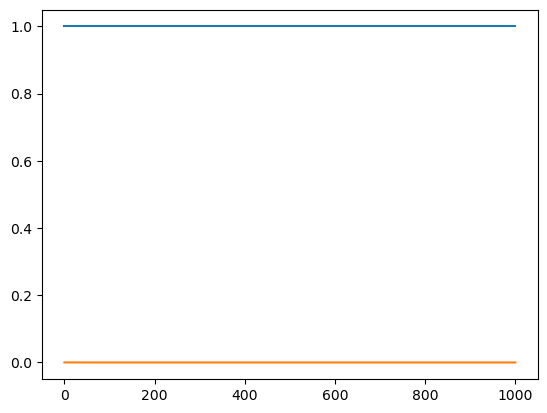

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F45A36590>

In [84]:
PyPlot.plot(in_thruster)
PyPlot.plot(in_rudder)

In [85]:
# plot(xs[1:100], ys[1:100])
# PyPlot.plot(xs, ys)

In [86]:
# plot(xs)
# plot!(ys)

## Measurement Model

In [87]:
size(value_image)


(8112, 16212)

lookup_depth (generic function with 1 method)

In [89]:
x = -100000000000
y = -1000000000000000000000
x_idx = argmin(abs.(collect(1:size(bathy_map, 2)) .- x))
y_idx = argmin(abs.(collect(1:size(bathy_map, 1)) .- y))
println(x_idx)
println(y_idx)

1
1


In [90]:
size(bathy_map)

# if 5 <= 1 || 4 <= 25
#     print("hi")
# end

(1001, 2001)

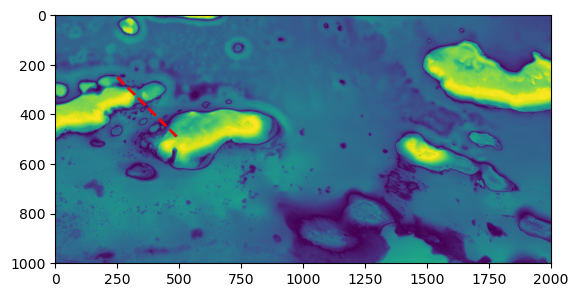

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F458C2440>

In [97]:

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)


# heatmap(bathy_map, aspect_ratio=:equal, color=:grays)
# plot!(600,600)
# plot!(x, y, color=:red, lw=2)
ax.plot([250,500],[250,500],"r--", lw=2)

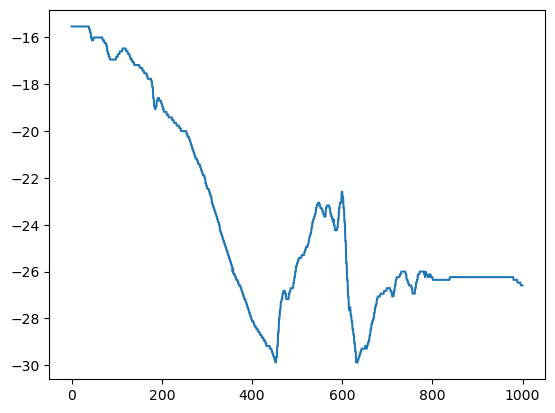

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F45639090>

In [99]:
measurements = simulate_measurements(xs, ys, bathy_map)
PyPlot.plot(ts, -measurements)

## Particle Filter

compute_likelihood (generic function with 1 method)

In [49]:
using Reel # For visualization
plot_sequence = []




5

In [50]:
# function sample_points(initial_state, noise_distribution, num_points)
#     ...
#     particles = ones(, N_PARTICLES)
    
#     for i in range(1, num_points)
#         sample = initial_state + rand.(initial_distribution)
#     end
    
#     return samples
# end

# function update_weights!(particles, dynamics_model, observation)
#     ...

# function compute_likelihood(state, observation, observation_model)
#     ...
        
#     # State vector: x, y, θ, linear velocity, angular velocity
#     x, y, θ, v, dθ = state

#     model_depth = lookup_depth(x, y, map)

#     dist = Normal(model_depth, MODEL_MEASUREMENT_STD)
#     pdf_value = pdf(dist, measurement)
    
# #     println(model_depth)
# #     println(pdf_value)
#     return pdf_value
# end

# function resample_points!(particles, weights)
#     ...
        

            

In [51]:
rand.([dist_pos_init, dist_pos_init])

2-element Vector{Float64}:
 -63.92874007791153
  96.68746732981522

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

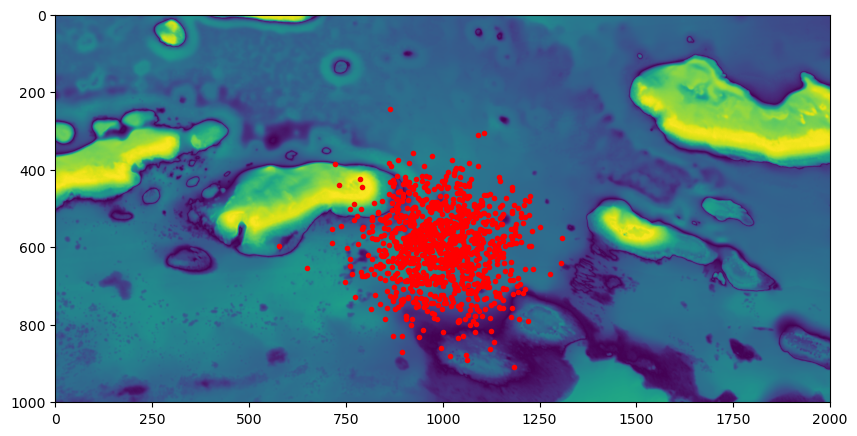

In [52]:

# INITIALIZATION ##############################################
all_particles = ones(STATE_VEC_SIZE, N_PARTICLES, N_STEPS)
particles = ones(STATE_VEC_SIZE, N_PARTICLES)
new_particles = ones(STATE_VEC_SIZE, N_PARTICLES)
weights = ones(N_PARTICLES)


dist_pos_init = Normal(0, INIT_STD_POS)
dist_rot_init = Normal(0, INIT_STD_ROT)

dist_pos_update = Normal(0, PF_STD_POS)
dist_rot_update = Normal(0, PF_STD_ROT)


for i in range(1, N_PARTICLES)
    # Generate sample
    x = START_X + rand(dist_pos_init)
    y = START_Y + rand(dist_pos_init)
    θ = START_θ + rand(dist_rot_init)
    
    particles[:,i] = particles[:,i].*[x, y, θ, 0, 0]
end

# Plot initial particles
fig, ax = PyPlot.subplots(figsize=[10,10])
ax.imshow(-bathy_map)
ax.plot(particles[1,:], particles[2,:], "r.")


# PARTICLE FILTER ##############################################
state_estimate = ones(STATE_VEC_SIZE, N_STEPS)

# pre-allocate space (avoids errors)
samples = similar(weights)

for (t_idx, (t, m, in_th, in_rud)) in enumerate(zip(ts, measurements, in_thruster, in_rudder))
    print('.')
    all_particles[:,:,t_idx] = particles
    
    
    # Update weights based on observation ---------------------
    # Compute relative likelihoods
    for (p_idx, p) in enumerate(eachcol(particles))
        weights[p_idx] = compute_likelihood(p, m, bathy_map)
        
        # Ensure likelihood can't be too small
        if weights[p_idx] < 0.000000001
            weights[p_idx] = 0.000000001
        end
    end   
    
    # Resample particles --------------------------------------
    # Normalize the weights

    
#     println("HEREEE")
#     println(size(weights))
#     println(sum(weights))
#     println(size(weights ./ sum(weights)))
    
    w_norm = Weights(weights ./ sum(weights))

    # Generate N_PARTICLES samples
    samples = sample(1:size(particles, 2), w_norm, N_PARTICLES)

    # Extract the corresponding columns from the matrix
    new_particles = particles[:, samples]
    particles = new_particles
    
    # Add noise to avoid particle death
    # TODO: Add noise to samples based on current covariances
    particles[1, :] = particles[1, :] + rand(dist_pos_update, N_PARTICLES)
    particles[2, :] = particles[2, :] + rand(dist_pos_update, N_PARTICLES)
    particles[3, :] = particles[3, :] + rand(dist_rot_update, N_PARTICLES)
    
    # Update particles with dynamics model 
    # TODO add vehicle dynamics noise? (build in noise term here)
    for (p_idx, p) in enumerate(eachcol(particles))
        particles[:,p_idx] = glider_dynamics_model(p, DELTA_T, in_th, in_rud)
    end   
    
    # Update state estimate --------------------------------------
    state_estimate[:,t_idx] = mean(particles, dims=2) # TODO: Handle angle wrap elegantly
    
#     # Visualization -------------------------------------------
#     fig, ax = PyPlot.subplots()
#     ax.imshow(-bathy_map)
#     ax.plot(particles[1,:], particles[2,:], "r.")

#     # Add the plot to the sequence
#     push!(plot_sequence, fig)
end



# w = [1,1,1,2,3,4,5,6,7]

# idxs = sample(axes(b, 1), myweights, 10)

# INITIALIZATION

# SIM_TIME = 1000 # s
# N_STEPS = 1001

# START_X = 1000 
# START_Y = 600
# START_θ = π/2

# state_vec = 
# particles



# Implement Particle filter
# - given
#     in_thruster
#     in_rudder
# - given initialization (put at map size/2)
# - randomly generate particles around starting position (x, y, theta) - Note: use gaussians here. Use defined covariance
# - plot initial particles

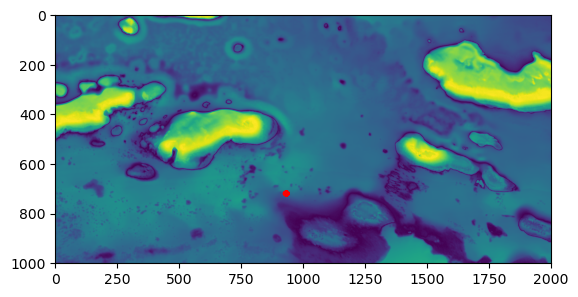

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F2BE626B0>

In [53]:
# Plot particles at step n

n = 100

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(all_particles[1,:,n], all_particles[2,:,n], "r.")

In [54]:
# # dist_pos_init = Normal(0, INIT_STD_POS)
# dist_rot_init = Normal(0, INIT_STD_ROT)
# rand(dist_pos_init, 10) + rand(dist_pos_init, 10)

In [55]:
# frames = Frames(MIME("image/png"), fps=10)
# for plt in plot_sequence
#     print(".")
#     push!(frames, plt)
# end
# write("output.gif", frames)


# using Interact, Plots

# Define the function to plot
# f(x) = sin(x)

# Create a slider widget
# s = slider(0:0.1:2π, label="x")

# # Create a plot that updates with the slider
# plot(slider = s) do
#     plot(f.(s.value), label="sin(x)")
#     xlabel("x")
#     ylabel("y")
#     ylim(-1.1, 1.1)
# end

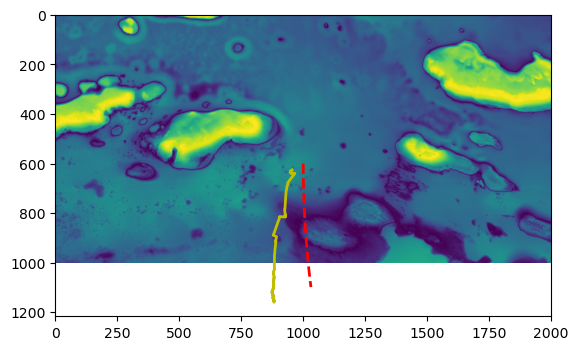

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F2BEE61A0>

In [56]:
# Plot result
# fig, ax = PyPlot.subplots(figsize=[10,10])
fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(state_estimate[1,:], state_estimate[2,:], "y-", lw=2)
ax.plot(xs,ys,"r--", lw=2)

In [26]:
# particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# A = rand(5, 10)
# row_means = mean(A, dims=2)

In [27]:
mat = rand(3,10)
display(mat)
print(size([1,1,1,1,1,2,3,4,5,100]))
w = pweights([1,1,1,1,1,2,3,4,5,1000])

idxs = sample(axes(mat,2), w, 10)

3×10 Matrix{Float64}:
 0.263024    0.534815  0.992894  0.480743  …  0.437964  0.832557  0.611114
 0.00397285  0.586192  0.795251  0.764921     0.831626  0.269864  0.142983
 0.696813    0.748456  0.229832  0.84537      0.990075  0.538914  0.956491

(10,)

10-element Vector{Int64}:
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10

In [28]:
# Example data
# mat = rand(3,10)
# w_unnormalized = [1,1,1,1,1,2,3,4,5,1000]
# p = w_unnormalized / sum(w_unnormalized)
# w = 1 ./ p
# w = w / sum(w)

# # Draw a sample from x using the weights in w
# sampled_index = sample(w_unnormalized, Weights(w), 1)

# Get the value of the sampled element from x
# sampled_value = x[1,sampled_index]



# RESAMPLE STEP #####################################


# Example data
mat = rand(3, 10)
w_unnormalized = [1, 1, 1, 1, 1, 2, 3, 4, 5, 1000]

# Normalize the weights
w = w_unnormalized ./ sum(w_unnormalized)

# Generate n samples
n = 5
samples = sample(1:size(mat, 2), Weights(w), n)

# Extract the corresponding columns from the matrix
sampled_mat = mat[:, samples]


3×5 Matrix{Float64}:
 0.595189   0.595189   0.393616  0.595189   0.595189
 0.0485249  0.0485249  0.147211  0.0485249  0.0485249
 0.921648   0.921648   0.819239  0.921648   0.921648

In [29]:
axes(mat,2)

Base.OneTo(10)

In [30]:
# using StatsBase

# # Define an array of values
# x = [2, 3, 5, 2, 10]

# # Compute weights based on the relative values of the elements in x
# w = x ./ sum(x)

# # Sample an index from x based on the computed weights
# # idx = rand(SampleWeights(w))


In [31]:
# bathy_map[1,400]
# bathy_map[1,800]
# maximum(bathy_map)
# minimum(bathy_map)
# plot(bathy_map[:,1]) # column, row format. 0, 0 is top left of image



In [32]:
print(img[10,10000])

# function rgb_to_greyscale(rgb)
# end
# 0.2989, 0.5870, 0.1140.

# gray_value = Gray(img[10,10000])

# gray_img = Gray.(img)

# # Plot the grayscale image
# heatmap(gray_img, color=:grays)

# float(red(img[6000,10000]))

rgb_to_value(img[6000,10000])

RGB{N0f8}(1.0,0.0,0.0)

12.941175f0

In [33]:

# # affine_map = geotransform(geoarray)
# # plot(geoarray, band=3)
# # geoarray
# # 0.299red+0.587green+0.114blue
# # band_1 = geoarray[:,:,1]

# using GeoArrays

# # Load the GeoTIFF file into a GeoArray
# # filename = "path/to/geotiff/file.tif"
# # geoarray = GeoArrays.read(filename)

# # Define the latitude and longitude of the point of interest
# lat = 40.7128
# lon = -74.0060

# # Convert the latitude and longitude to row and column indices
# # setcrs!(geoarray, "+proj=longlat +datum=WGS84")
# # row, col = GeoArrays.coordinates(geoarray, lat, lon)

# # # Extract the RGB value at the specified location
# # rgb = geoarray[row, col, :]

# # # Convert the RGB value to depth
# # depth = 0.3048 * (rgb[1] + rgb[2] * 256 + rgb[3] * 65536)

# # # Print the depth value
# # println(depth)

In [34]:
# Define the x and y values
x = 100
y = 200

# Find the pixel with the closest x, y values
x_idx = argmin(abs.(collect(1:size(img, 2)) .- x))
y_idx = argmin(abs.(collect(1:size(img, 1)) .- y))

# Look up the pixel value
pixel_value = img[y_idx, x_idx]
print(pixel_value)

RGB{N0f8}(0.69,0.882,0.0)

### Map Generation

In [35]:
using Plots
using CalculusWithJulia
import Contour: contours, levels, lines, coordinates
using LinearAlgebra, ForwardDiff

LoadError: ArgumentError: Package CalculusWithJulia not found in current path.
- Run `import Pkg; Pkg.add("CalculusWithJulia")` to install the CalculusWithJulia package.

In [36]:
# Step 1
n = rand(5:20)

# Step 2
A = rand(-1:0.01:1, n)
B = rand(0.001:0.005:0.05, n)
f_rand(x,y) = sum(A[i]*sin.(B[i]*x) * A[i+1]*cos.(B[i+1]*y) for i in 1:n-1)


f_rand (generic function with 1 method)

In [37]:
xs = range(-200, stop=200, length=100)
ys = range(-200, stop=200, length=100)
# f(x,y) = sin(x/100)*sin(y/100)
# f(x,y) = sin(x/100)*sin(y/100)
# surface(xs, ys, f)
contour(xs, ys, f_rand)

LoadError: UndefVarError: contour not defined

In [38]:
f_rand(xs, ys)

LoadError: MethodError: no method matching *(::Vector{Float64}, ::Vector{Float64})
[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:591
[0m  *([91m::StridedMatrix{T}[39m, ::StridedVector{S}) where {T<:Union{Float32, Float64, ComplexF32, ComplexF64}, S<:Real} at C:\Users\amyng\AppData\Local\Programs\Julia-1.8.5\share\julia\stdlib\v1.8\LinearAlgebra\src\matmul.jl:49
[0m  *(::StridedVecOrMat, [91m::LinearAlgebra.Adjoint{<:Any, <:LinearAlgebra.LQPackedQ}[39m) at C:\Users\amyng\AppData\Local\Programs\Julia-1.8.5\share\julia\stdlib\v1.8\LinearAlgebra\src\lq.jl:269
[0m  ...

In [39]:
using PyPlot

In [40]:
function meshgrid(x, y)
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    return X, Y
end

meshgrid (generic function with 1 method)

### Lookup values

In [ ]:
function simulate_measurement(x,y,theta,noise=0)
    # TODO: Returns beam 1, 2, 3, 4
    return f_rand(x, y)
end

In [ ]:
# End goal: plot of real trajectory, 
# versus computed one with particle filter

## GPU code snippets

In [ ]:
# # Initialize particles
# x_d = CuArray{Float32}(START_X .+ rand(dist_pos_init, N_PARTICLES))
# y_d = CuArray{Float32}(START_Y .+ rand(dist_pos_init, N_PARTICLES))
# θ_d = CuArray{Float32}(START_θ .+ rand(dist_rot_init, N_PARTICLES))
# v_d = CUDA.fill(0.0f0, N_PARTICLES)  # a vector stored on the GPU filled with 1.0 (Float32)
# dθ_d = CUDA.fill(0.0f0, N_PARTICLES)

# # Particles = Vector containing CuArray for each state variable 
# # Vector{CuArray}(undef, 5)
# particles_d = CuArray([x_d, y_d, θ_d, v_d, dθ_d])

# # Load measurements and control inputs onto GPU
# in_thruster_d = CuArray{Float32}(in_thruster)
# in_rudder_d = CuArray{Float32}(in_rudder)

# inputs_d = [in_thruster_d, in_rudder_d]
# measurements_d = [CuArray{Float32}(measurements)]


In [ ]:
# in_thruster_32 = Float32.(in_thruster)
# in_rudder_32 = Float32.(in_rudder)

# temp = [[x, y] for (x, y) in zip(in_thruster_32, in_rudder_32)]
# a_d = CuArray(map(x -> (x[1], x[2]), temp))

# # inputs_d = cu(zip(in_thruster_32, in_rudder_32))

# # inputs_d[1]
# # [in_thruster_32, in_rudder_32]

# in_thruster_32 = Float32.(in_thruster)
# in_rudder_32 = Float32.(in_rudder)
# inputs_d = cu([in_thruster_32', in_rudder_32'])
# [in_thruster_32, in_rudder_32]

In [ ]:
# Load initial particles onto GPU (_d means stored on device)
using CUDA

# Initialize particles
x = Float32.(START_X .+ rand(dist_pos_init, N_PARTICLES))
y = Float32.(START_Y .+ rand(dist_pos_init, N_PARTICLES))
θ = Float32.(START_θ .+ rand(dist_rot_init, N_PARTICLES))
v = zeros(Float32, N_PARTICLES)
dθ = zeros(Float32, N_PARTICLES)

# Particles = Vector containing CuArray for each state variable 
# Vector{CuArray}(undef, 5)
particles = [broadcast(tuple, x[i], y[i], θ[i], v[i], dθ[i]) for i in 1:length(x)]
particles_d = CuArray(map(x -> (x[1], x[2], x[3], x[4], x[5]), particles))

# Load measurements and control inputs onto GPU
in_thruster_32 = Float32.(in_thruster)
in_rudder_32 = Float32.(in_rudder)
inputs = [[x1, x2] for (x1, x2) in zip(in_thruster_32, in_rudder_32)]
inputs_d = CuArray(map(x -> (x[1], x[2]), inputs))

measurements_32 = Float32.(measurements)
measurements_d = CuArray(map(x -> (x[1],), measurements_32));